In [16]:
import tensorflow as tf 
import numpy as np
import pandas as pd 
import os 
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
#!pip3 install tensorflow_datasets
import tensorflow_datasets as tfds

In [17]:
# for dirname, _, filenames in os.walk('./data/kaggle_tutorial/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [18]:
dataframes = [] 
folder_path = './data/kaggle_tutorial/'
for file in os.listdir(folder_path): 
    df2 = pd.read_csv(f'{folder_path}{file}', delimiter=';', header=None, names=['sentence', 'label'])
    if df2.shape[0] > 1000 and file != 'tweets.csv':
        print(file)
        print(df2.shape)
        dataframes.append(df2)
df2 = pd.concat(dataframes, axis=0)


df1 = pd.read_csv('./data/kaggle_tutorial/tweets.csv')
df1.drop(df1.columns[df1.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df1 = df1.dropna()
print()
print(df1.shape)
print(df2.shape)

df = pd.concat([df2, df1], axis=0)
df = df.sample(frac=1).reset_index(drop=True)
print(df.groupby('label').count())
df.head()

# now drop about 5000 from joy and sadness to ballance out the classes 

val.txt
(2000, 2)
test.txt
(2000, 2)
train.txt
(16000, 2)

(29899, 2)
(20000, 2)
          sentence
label             
anger         4412
fear          4492
joy          11945
love          5428
sadness      12285
surprise      2902
worry         8435


,sentence,label
0,wah....American Chocolate Cheese Cake for my c...,joy
1,i am less sensitive and my feelings are less e...,sadness
2,i wish i had friends i could spend the night with,worry
3,I know I have lots of emails to answer! I will...,worry
4,trying to find some friends and not having any...,worry


In [19]:
""" I'm ballancing the classes here (roughly) hopefully to improve performance """
do_nothing_to = ['love', 'anger', 'fear', 'surprise', 'worry']
drop_last_5000_from = ['joy', 'sadness']
dfa = df[df['label']=='love']
dfb = df[df['label']=='anger']
dfc = df[df['label']=='fear']
dfd = df[df['label']=='surprise']
dfe = df[df['label']=='worry']

dff = df[df['label']=='joy']
dff = dff.sample(frac=1).reset_index(drop=True)
dff.drop(dff.tail(5500).index, inplace=True)
dfg = df[df['label']=='sadness']
dfg = dfg.sample(frac=1).reset_index(drop=True)
dfg.drop(dfg.tail(5500).index, inplace=True)

df = pd.concat([dfa,dfb,dfc,dfd,dfe,dff,dfg], axis=0)
df = df.sample(frac=1).reset_index(drop=True)

print(df.groupby('label').count())

          sentence
label             
anger         4412
fear          4492
joy           6445
love          5428
sadness       6785
surprise      2902
worry         8435


In [20]:
from sklearn.preprocessing import LabelEncoder
# this is an important preprocessing step to make computer better at interpreting data 
labelencoder = LabelEncoder()
df['label_enc'] = labelencoder.fit_transform(df['label'])
df.head()

,sentence,label,label_enc
0,- New forest hoping the walk would lose me som...,worry,6
1,youre not supposed to...,worry,6
2,I don't wanna go to work,sadness,4
3,i dont really have any details to share but i ...,joy,2
4,JB on the front of factor x!!!!! wooh contest ...,worry,6


In [21]:
df.rename(columns={'label': 'label_desc', 'label_enc': 'label'}, inplace=True)
df.head()

,sentence,label_desc,label
0,- New forest hoping the walk would lose me som...,worry,6
1,youre not supposed to...,worry,6
2,I don't wanna go to work,sadness,4
3,i dont really have any details to share but i ...,joy,2
4,JB on the front of factor x!!!!! wooh contest ...,worry,6


In [22]:
from sklearn.model_selection import train_test_split
sentences = df['sentence'].values
labels = df['label'].values
training_sentences, validation_sentences, training_labels, validation_labels = train_test_split(sentences, labels, random_state=41,test_size=0.1)

In [23]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [24]:
tokenizer([training_sentences[0]], truncation=True,
                            padding=True, max_length=64)

{'input_ids': [[101, 3666, 7097, 7808, 2208, 2487, 4826, 2305, 2065, 3087, 2003, 4699, 1010, 1998, 1045, 2113, 2008, 3904, 1997, 2017, 2024, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [25]:
type(training_sentences)
train_encodings = tokenizer(list(training_sentences),
                            truncation=True,
                            padding=True)
val_encodings = tokenizer(list(validation_sentences),
                            truncation=True,
                            padding=True)

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    training_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    validation_labels
))

In [27]:
num_labels = len(df['label'].unique())
print(num_labels, df['label'].unique())

7 [6 4 2 1 0 3 5]


In [28]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=num_labels)


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])
model.fit(train_dataset.shuffle(100).batch(32),
          epochs=2,
          batch_size=32,
          validation_data=val_dataset.shuffle(100).batch(32))

Epoch 1/9
1095/1095 [==============================] - 3966s 4s/step - loss: 0.4111 - accuracy: 0.8492 - val_loss: 1.0618 - val_accuracy: 0.6589
Epoch 2/9
1095/1095 [==============================] - 3919s 4s/step - loss: 0.2794 - accuracy: 0.8993 - val_loss: 1.2386 - val_accuracy: 0.6735
Epoch 3/9
1095/1095 [==============================] - 3923s 4s/step - loss: 0.2032 - accuracy: 0.9278 - val_loss: 1.5146 - val_accuracy: 0.6702
Epoch 4/9
1095/1095 [==============================] - 3994s 4s/step - loss: 0.1568 - accuracy: 0.9448 - val_loss: 1.5518 - val_accuracy: 0.6717
Epoch 5/9
1095/1095 [==============================] - 3997s 4s/step - loss: 0.1176 - accuracy: 0.9593 - val_loss: 1.6894 - val_accuracy: 0.6663
Epoch 6/9
1095/1095 [==============================] - 4034s 4s/step - loss: 0.1021 - accuracy: 0.9661 - val_loss: 1.6338 - val_accuracy: 0.6522
Epoch 7/9
1095/1095 [==============================] - 3920s 4s/step - loss: 0.0851 - accuracy: 0.9718 - val_loss: 1.7739 - val_ac

In [42]:
model_path = './new_BERT_model'
# !mkdir -p {model_path}
model.save_pretrained(model_path)

In [33]:
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(model_path)

Some layers from the model checkpoint at ./new_BERT_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./new_BERT_model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
test_sentence = "i can't understand you, idiot"
predict_input = tokenizer.encode(test_sentence,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

tf_output = loaded_model.predict(predict_input)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)
labels = [0,1,2,3,4,5,6]
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print(labels[label[0]])

6


In [36]:
df[['label','label_desc']].drop_duplicates(keep='first')

,label,label_desc
0,6,worry
2,4,sadness
3,2,joy
5,1,fear
7,0,anger
10,3,love
26,5,surprise


In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
pred = []
for text in validation_sentences:
    pred_input = tokenizer.encode(text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")
    tf_output = loaded_model.predict(pred_input)[0]
    tf_prediction = tf.nn.softmax(tf_output, axis=1)
    labels = [0,1,2,3,4,5,6] # for some reason this needs to be in order and not in random order! 
    #print(labels)
    label = tf.argmax(tf_prediction, axis=1)
    label = label.numpy()
    pred.append(labels[label[0]])
    

    
    


In [45]:
print(classification_report(validation_labels, pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       422
           1       0.86      0.84      0.85       465
           2       0.71      0.66      0.68       644
           3       0.62      0.61      0.62       530
           4       0.72      0.59      0.65       685
           5       0.38      0.34      0.36       300
           6       0.52      0.66      0.59       844

    accuracy                           0.66      3890
   macro avg       0.67      0.65      0.66      3890
weighted avg       0.67      0.66      0.66      3890



In [83]:
print(df['label'].unique())
print(validation_labels[:10])
print(pred[:10])
df['label'].unique()
pred = np.array(pred)
pred = pd.DataFrame(pred, columns=['a'])
print(pred.a.value_counts())
val = np.array(validation_labels)
val = pd.DataFrame(val, columns=['a'])
print(val.a.value_counts())

[4 3 0 2 1 5]
[4 2 3 4 2 2 4 4 4 2]
[4, 1, 2, 5, 1, 5, 3, 1, 1, 0]
0    742
1    568
4    283
3    215
2    132
5     60
Name: a, dtype: int64
2    723
4    577
0    291
1    198
3    147
5     64
Name: a, dtype: int64


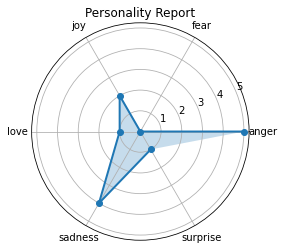

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
labels=np.array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])
stats = [5, 0, 2, 1, 4, 1]
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
# angles=np.concatenate((angles,[angles[0]]))

fig=plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2)
ax.fill(angles, stats, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.set_title('Personality Report')
ax.grid(True)
fig.savefig('./fig.png')